<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Traductor
Ejemplo basado en [LINK](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/)

### Consignas
Replicar y extender el traductor:
- Replicar el modelo en PyTorch.
- Extender el entrenamiento a más datos y tamaños de
secuencias mayores.
- Explorar el impacto de la cantidad de neuronas en
las capas recurrentes.
- Mostrar 5 ejemplos de traducciones generadas.
- Extras que se pueden probar: Embeddings
pre-entrenados para los dos idiomas; cambiar la
estrategia de generación (por ejemplo muestreo
aleatorio);

### Datos
El objetivo es utilizar datos disponibles del Tatoeba Project de traducciones de texto en diferentes idiomas.  
Se construirá un modelo traductor de inglés a español seq2seq utilizando encoder-decoder.  
[LINK](https://www.manythings.org/anki/)

In [1]:
import requests
import os
from zipfile import ZipFile
import numpy as np

In [2]:
# Funcion auxiliar para descargar el dataset
def download_dataset(dataset_url: str, target_dir: str, check_dir: str | None = None, force: bool = False, tmp_file: str = "tmp.zip", unzip: bool = True):

    if check_dir and os.path.isdir(check_dir) and not force:
        print("Check folder already exists, nothing downloaded.")
        return

    try:
        with requests.get(dataset_url, stream=True, allow_redirects=True) as response:
            response.raise_for_status()  # Raise an exception for bad status codes

            with open(tmp_file, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
        print(f"File '{tmp_file}' downloaded successfully.")
    except requests.exceptions.RequestException as e:
        if (os.path.isfile(tmp_file)):
            os.remove(tmp_file)
        raise(Exception(f"Error downloading file: {e}"))

    if not unzip:
        return
    try:
        with ZipFile(tmp_file, 'r') as zip_object:
            zip_object.extractall(target_dir)
        print(f"Successfully extracted '{tmp_file}' to '{target_dir}'.")

    except FileNotFoundError:
        raise(Exception(f"Error: The file '{tmp_file}' was not found."))
    except Exception as e:
        raise(Exception(f"An error occurred: {e}"))
    finally:
        if (os.path.isfile(tmp_file)):
            os.remove(tmp_file)


In [3]:
dataset_url = "http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
base_dir = "./"
folder_dir = "spa-eng"
download_dataset(dataset_url, base_dir, check_dir=folder_dir, tmp_file="spa-eng.zip")

Check folder already exists, nothing downloaded.


In [4]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada y salida
max_input_len = 16
max_out_len = 18

In [5]:
# dataset_file

text_file = os.path.join(base_dir, folder_dir, "spa.txt")
with open(text_file, encoding="utf8") as f:
    lines = f.read().split("\n")[:-1]

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

for line in lines:
    # el tabulador señaliza la separación entre las oraciones 
    # en ambos idiomas
    if '\t' not in line: 
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # Limito las longitudes de sentencias
    if (len(input_sentence.split(" ")) > max_input_len) \
        or (len(output.split(" ")) > max_out_len):
        continue

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 118472


In [6]:
import random
# Solo me quedo con una fracción de textos
MAX_NUM_SENTENCES = 30000

random.seed(42)
rnd_idx = random.sample(range(len(input_sentences)), min(MAX_NUM_SENTENCES, len(input_sentences))) # Al azar
# rnd_idx = range(min(MAX_NUM_SENTENCES, len(input_sentences))) # Primeros n
input_sentences = [input_sentences[i] for i in rnd_idx]
output_sentences = [output_sentences[i] for i in rnd_idx]
output_sentences_inputs = [output_sentences_inputs[i] for i in rnd_idx]

In [7]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0], len(input_sentences)

('There is no doubt about his ability.',
 'No hay ninguna duda sobre su habilidad. <eos>',
 '<sos> No hay ninguna duda sobre su habilidad.',
 30000)

### 2 - Preprocesamiento

In [8]:
from collections import Counter
# Tokenizar las palabras, similar a Tokenizer de Keras
class Tokenizer():
    def __init__(self, num_words: int | None = None, filters: str = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
        self.num_words = num_words - 1 if num_words else None # Reservo el indice 0 para padding
        self.filters = filters
        self.word_index = {}

    def __preprocess_text(self, text: str) -> list[str]:
        # Quito caracteres especiales y paso todo a minusculas
        text = ''.join(' ' if char in self.filters else char for char in text.lower())
        return [word for word in text.split(' ') if word]

    def fit_on_texts(self, input_sentences: list[str], force_include: list[str] = []) -> None:
        if (len(self.word_index) != 0):
            raise(Exception("Tokenizer has already been fit."))
        # Guardo cantidad de apariciones de cada palabra
        counter = Counter()
        for text in input_sentences:
            sentence = self.__preprocess_text(text)
            if not sentence: continue
            counter.update(sentence)

        # Selecciono las más comunes, si es que se indica máximo
        most_common_n_words = counter.most_common(self.num_words)
        # Fuerzo la inclusion de ciertas palabras
        # ya que podrían quedar fuera por no se tan comunes
        # (pasa con <eos> ya que se fittea con las frases que no lo contienen)
        for forced in reversed(force_include):
            if forced not in tuple(zip(*most_common_n_words))[0]:
                most_common_n_words.insert(0, (forced, 0))
        # Si se insertó alguna palabra forzada tengo que volver
        # a quedarme con las N mas comunes (o todas si no se indica)
        most_common_n_words = most_common_n_words[:self.num_words]
        # Calculamos indices para cada palabra, empezando en 1 (igual que Keras)
        self.word_index = { word: i+1 for i, (word, _) in enumerate(most_common_n_words)}

    def texts_to_sequences(self, input_sentences: list[str]):
        if (len(self.word_index) == 0):
            raise(Exception("Tokenizer has not been fit yet."))
        input_integer_seq = []
        for tokens in input_sentences:
            tokens = self.__preprocess_text(tokens)
            if not tokens: continue
            sequence = [self.word_index[word] for word in tokens if word in self.word_index]
            input_integer_seq.append(sequence)
        return input_integer_seq

In [9]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 10000
# Vamos a necesitar un tokenizador para cada idioma

In [10]:
# tokenizador de inglés
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 8045
Sentencia de entrada más larga: 17


In [11]:
word2idx_inputs

{'the': 1,
 'i': 2,
 'to': 3,
 'you': 4,
 'tom': 5,
 'a': 6,
 'is': 7,
 'he': 8,
 'in': 9,
 'of': 10,
 'that': 11,
 'it': 12,
 'was': 13,
 'me': 14,
 'do': 15,
 'this': 16,
 'have': 17,
 'my': 18,
 'for': 19,
 'she': 20,
 "don't": 21,
 'are': 22,
 'what': 23,
 'his': 24,
 'we': 25,
 'on': 26,
 'mary': 27,
 'your': 28,
 'be': 29,
 'want': 30,
 'with': 31,
 "i'm": 32,
 'not': 33,
 'like': 34,
 'and': 35,
 'know': 36,
 'at': 37,
 'him': 38,
 'can': 39,
 'go': 40,
 'her': 41,
 'has': 42,
 'there': 43,
 'did': 44,
 'will': 45,
 'they': 46,
 'how': 47,
 'very': 48,
 "it's": 49,
 'as': 50,
 'time': 51,
 'all': 52,
 'here': 53,
 'had': 54,
 'about': 55,
 'up': 56,
 'think': 57,
 "didn't": 58,
 'when': 59,
 "can't": 60,
 'get': 61,
 'from': 62,
 'out': 63,
 'were': 64,
 'no': 65,
 'one': 66,
 'if': 67,
 'an': 68,
 'going': 69,
 "doesn't": 70,
 'good': 71,
 'see': 72,
 'would': 73,
 'come': 74,
 'why': 75,
 'by': 76,
 'who': 77,
 'please': 78,
 'need': 79,
 "you're": 80,
 'been': 81,
 'just': 82

In [12]:
# tokenizador de español
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(output_sentences, force_include=["<sos>", "<eos>"])
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 9999
Sentencia de salida más larga: 19


In [13]:
print(f"Sentencia de entrada más larga: {max_input_len}.")
print(f"Sentencia de salida más larga: {max_out_len}.")

Sentencia de entrada más larga: 17.
Sentencia de salida más larga: 19.


In [14]:
for sec in output_tokenizer.texts_to_sequences(["<sos>", "<eos>"]):
    assert sec, "El tokenizador debe incluir <sos> y <eos>"

A la hora de realizar padding es importante tener en cuenta que en el encoder los ceros se agregan al comienzo y en el decoder al final.  
Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [15]:
def pad_sequences(sequences, maxlen=None, dtype='int32', padding_pre=True, value=0.0):
    if maxlen is None:
        maxlen = max(len(s) for s in sequences)

    out_secuences = []
    for secuence in sequences:
        if len(secuence) <= maxlen: # Hago padding hasta max_len
            if padding_pre:
                sec_out = [value] * (maxlen - len(secuence)) + secuence
            else:
                sec_out = secuence + [value] * (maxlen - len(secuence))
        else: # O me quedo con los max_len caracteres
            if padding_pre:
                sec_out = secuence[-maxlen:]
            else:
                sec_out = secuence[:maxlen]
        out_secuences.append(sec_out)

    return np.array(out_secuences, dtype=dtype)

In [16]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding_pre=False)
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 30000
encoder_input_sequences shape: (30000, 17)
decoder_input_sequences shape: (30000, 19)


In [17]:
encoder_input_sequences[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   43,
          7,   65,  915,   55,   24, 1835])

In [18]:
decoder_input_sequences[0]

array([   1,    6,   55,  503, 1045,  139,   19, 3779,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])

In [19]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding_pre=False)
decoder_targets = decoder_output_sequences
decoder_targets.shape

(30000, 19)

In [20]:
decoder_output_sequences[0]

array([   6,   55,  503, 1045,  139,   19, 3779,    2,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])

### 3 - Preparar los embeddings

In [21]:
url = 'https://drive.usercontent.google.com/download?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t&uuid=07c897f9-d9a1-4bdd-8cce-70c9dca2368a&at=AKSUxGMQs76z20Q73h7ULNM9qfje%3A1759553933720'
output = 'gloveembedding.pkl'
if os.access(os.path.join(base_dir, output), os.F_OK) is False:
    download_dataset(url, base_dir, tmp_file=output, unzip=False)
else:
    print(f"Los embeddings {output} ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


In [22]:
from abc import abstractmethod

# Clase generica para definir los modelos de embeddings
class WordsEmbeddings(object):
    def __init__(self, num_features, word2idx, frozen) -> None:
        self.num_features = num_features
        self.word2idx = word2idx
        self.frozen = frozen
        self.__create_emb_matrix()

    @property
    def get_num_features(self) -> int:
        return self.num_features

    @property
    def get_frozen(self) -> int:
        return self.frozen

    @property
    def get_embedding_matrix(self):
        return self.embedding_matrix
    
    @abstractmethod
    def get_word_embedding(self, word) -> list[float] | None:
        pass

    # Crear la Embedding matrix de las secuencias
    def __create_emb_matrix(self):
        
        print('preparing embedding matrix...')
        words_not_found = []

        nb_words = len(self.word2idx) + 1 # vocab_size
        embedding_matrix = np.zeros((nb_words, self.get_num_features))
        for word, i in self.word2idx.items():
            if i >= nb_words: # se tendrán nb_words-1 words, porque el 0 es para unknown
                break
            embedding_vector = self.get_word_embedding(word)
            if (embedding_vector is not None) and any(v != 0.0 for v in embedding_vector):
                embedding_matrix[i] = embedding_vector
            else:
                # words not found in embedding index will be all-zeros.
                words_not_found.append(word)

        print('number of null word embeddings:', np.sum(np.any(embedding_matrix, axis=1) == 0))
        print(f"Words not found: {words_not_found}")
        self.embedding_matrix = embedding_matrix

In [23]:
import logging
import os
from pathlib import Path
import pickle

# Clase para manejar los embeddings de Glove
class GloveEmbeddings(WordsEmbeddings):
    logger = logging.getLogger(__name__)

    def __init__(self, word2idx, frozen):
        self.PKL_PATH = 'gloveembedding.pkl'
        self.N_FEATURES = 50

        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            raise Exception("Words embedding not available")
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.glove_word2idx = dict(zip(self.embeddings['word'], index))
        self.glove_idx2word = dict(zip(index, self.embeddings['word']))

        super().__init__(self.N_FEATURES, word2idx, frozen)

    def get_word_embedding(self, word) -> list[float] | None:
        word_idx = self.word_2_idx(word)
        return self.embeddings[word_idx]['embedding']

    def word_2_idx(self, word):
        return self.glove_word2idx.get(word, -1)

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

In [24]:
# Clase para manejar embeddings vacios
class Empty_Embeddings(WordsEmbeddings):
    def __init__(self, embedding_size, word2idx) -> None:
        super().__init__(embedding_size, word2idx, frozen=False)

    def get_word_embedding(self, word) -> list[float] | None:
        return None

In [25]:
%pip install --quiet fasttext-wheel
import fasttext.util
# Clase para manejar los embeddings de Fasttext
class Fasttext_Embeddings(WordsEmbeddings):
    def __init__(self, lang, embedding_size, word2idx, frozen) -> None:
        fasttext.util.download_model(lang, if_exists='ignore')
        self.model = fasttext.load_model(f'cc.{lang}.300.bin')
        fasttext.util.reduce_model(self.model, embedding_size)
        super().__init__(self.model.get_dimension(), word2idx, frozen)

    def get_word_embedding(self, word) -> list[float] | None:
        return self.model.get_word_vector(word).tolist()

Note: you may need to restart the kernel to use updated packages.


In [26]:
# Clase concreta para embeddings Fasttext en ingles
class Fasttext_en_Embeddings(Fasttext_Embeddings):
    def __init__(self, embedding_size, word2idx, frozen) -> None:
        super().__init__("en", embedding_size, word2idx, frozen)

# Clase concreta para embeddings Fasttext en español
class Fasttext_es_Embeddings(Fasttext_Embeddings):
    def __init__(self, embedding_size, word2idx, frozen) -> None:
        super().__init__("es", embedding_size, word2idx, frozen)


In [27]:
embedding_glove_eng = GloveEmbeddings(word2idx_inputs, frozen=True)
embedding_fasttext_eng = Fasttext_en_Embeddings(100, word2idx_inputs, frozen=True)
embedding_fasttext_esp = Fasttext_es_Embeddings(100, word2idx_outputs, frozen=True)
embedding_empty_esp = Empty_Embeddings(50, word2idx_outputs)

preparing embedding matrix...
number of null word embeddings: 376
Words not found: ["don't", "i'm", "it's", "didn't", "can't", "doesn't", "you're", "i'll", "i've", "he's", "isn't", "tom's", "that's", "let's", "i'd", "we're", "there's", "what's", "won't", "couldn't", "wasn't", "mary's", "she's", "they're", "you'll", "haven't", "we'll", "wouldn't", "you've", "aren't", "shouldn't", "we've", '30', "you'd", "who's", "hasn't", '2', "it'll", "he'll", "where's", "he'd", "weren't", "must've", "should've", "father's", "we'd", "hadn't", '10', "driver's", "they'll", "she'll", "today's", '5', '6', '00', '000', '3', "here's", "mother's", '100', "could've", '8', "would've", "how's", "people's", "son's", "patient's", "that'll", '50', "one's", "someone's", '20', "something's", "everyone's", "they've", "john's", "somebody's", "man's", '500', '2013', "japan's", "she'd", "what'll", '7', '20th', '65', "what're", "who'll", '11', "mustn't", "doctor's", '24', "grandfather's", "everything's", '1939', '200', "w

In [28]:
# Dimensión de los embeddings de las secuencias
embedding_glove_eng.embedding_matrix.shape, embedding_fasttext_eng.embedding_matrix.shape, embedding_fasttext_esp.embedding_matrix.shape, embedding_empty_esp.embedding_matrix.shape

((8046, 50), (8046, 100), (10000, 100), (10000, 50))

### 4 - Entrenar el modelo

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, embedding_model, dropout = 0.2, lstm_size = 128, num_layers = 1):
        super().__init__()
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        embedding_matrix = embedding_model.get_embedding_matrix
        freeze_emb = embedding_model.get_frozen
        self.embedding_dim = embedding_matrix.shape[1]
        
        # El tamaño del embedding lo toma directamente de la matriz que se creó antes
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embedding_matrix).float(), freeze=freeze_emb, padding_idx=0)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=dropout if num_layers != 1 else 0) # LSTM layer
        # Agrego dropout para mejorar el entrenamiento
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        try:
            out = self.dropout(self.embedding(x))
        except Exception:
            print("encoder")
            raise(Exception)
        _, (ht, ct) = self.lstm(out) # Del encoder solo se usa h y c
        return (ht, ct)

idx2word_target = {v:k for k, v in word2idx_outputs.items()}
class Decoder(nn.Module):
    def __init__(self, embedding_model, dropout = 0.2, lstm_size = 128, num_layers = 1):
        super().__init__()
        # num_embeddings = vocab_size, definido por el Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        embedding_matrix = embedding_model.get_embedding_matrix
        freeze_emb = embedding_model.get_frozen        
        self.embedding_dim = embedding_matrix.shape[1]
        self.output_dim = embedding_matrix.shape[0]

        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embedding_matrix).float(), freeze=freeze_emb, padding_idx=0)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=dropout if num_layers != 1 else 0) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer
        # Agrego dropout para mejorar el entrenamiento
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, prev_state):
        try:
            out = self.dropout(self.embedding(x))
        except Exception as e:
            print(f"decoder {input} - {idx2word_target[x]}")
            raise(e)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        # Con softmax no funciona, la salida pura si
        # out = self.softmax(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        # Sospecho que es porque en CrossEntropyLoss fue necesario (ignore_index=0)
        # y con softmax estamos modificando el 0
        out = self.fc1(lstm_output[:,-1,:])
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.lstm_size == decoder.lstm_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, encoder_input, decoder_input, teacher_forcing_ratio):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim
        # tensor para almacenar la salida
        # (batch_size, sentence_len, vocab_size)
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size).to(self.device)
            
        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)
        # En la primera vuelta no tengo predicción previa, por lo que uso el token de <sos>
        # sea teacher forcing o no
        top1 = decoder_input[:, 0:1]

        for t in range(decoder_input_len):
            # t --> token index

            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio

            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = decoder_input[:, t:t+1] if teacher_force else top1

            # ingresar cada token embedding, uno por uno junto al hidden state
            # recibir el output del decoder
            output, prev_state = self.decoder(input, prev_state)

            # guardar cada salida
            outputs[:, t, :] = output

            # get the highest predicted token from our predictions
            top1 = output.argmax(1, keepdim=True)

        return outputs

In [30]:
from torch.utils.data import Dataset, DataLoader

class TranslatorDataset(Dataset):
    def __init__(self, encoder_input_sequences, decoder_input_sequences, decoder_targets):
        self.encoder_input_sequences = torch.tensor(encoder_input_sequences, dtype=torch.int)
        self.decoder_input_sequences = torch.tensor(decoder_input_sequences, dtype=torch.int)
        self.decoder_targets = torch.tensor(decoder_targets, dtype=torch.long)

    def __len__(self):
        return len(self.encoder_input_sequences)

    def __getitem__(self, idx):
        return (self.encoder_input_sequences[idx],
                self.decoder_input_sequences[idx],
                self.decoder_targets[idx])

In [31]:
encoder_input_sequences.shape, decoder_input_sequences.shape, decoder_targets.shape

((30000, 17), (30000, 19), (30000, 19))

In [32]:
from torch.utils.data import random_split

full_dataset = TranslatorDataset(encoder_input_sequences, decoder_input_sequences, decoder_targets)

train_size = int(0.8 * len(full_dataset))  # 80% for training
test_size = len(full_dataset) - train_size  # Remaining 20% for testing
train_dataset, val_dataset = random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

print(f"Train size: {len(train_dataset)}. Validation size: {len(val_dataset)}")

Train size: 24000. Validation size: 6000


In [33]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [34]:
def calculate_accuracy(outputs, labels):
    predicted = outputs.argmax(dim=2)
    total = labels.size(0) * labels.size(1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

def train(model, train_loader, valid_loader, optimizer, criterion, device, epochs=20, clip = 1.0, teacher_forcing_ratio = 0.8, model_filename = "model.pt"):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []
    best_valid_loss = float("inf")

    # Defino mi loop de entrenamiento
    model.to(device)
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_encoder_input, train_decoder_input, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_encoder_input.to(device), train_decoder_input.to(device), teacher_forcing_ratio)
            train_target = train_target.to(device)
            # Computo el error de la salida comparando contra las etiquetas
            # por cada token en cada batch (sequence_loss)
            loss = 0
            # for t in range(output.shape[1]):
            #     loss += criterion(output[:, t, :], train_target[:, t, :])
            loss = criterion(output.view(-1, output.shape[-1]), train_target.view(-1))

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # clip the gradients to prevent them from exploding (a common issue in RNNs)
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            # accuracy = sequence_acc(output, train_target)
            epoch_train_accuracy += calculate_accuracy(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            # epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss /= len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy /= len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        model.eval()
        epoch_valid_loss = 0
        epoch_valid_accuracy = 0
        with torch.no_grad():
            for valid_encoder_input, valid_decoder_input, valid_target in valid_loader:
                # Realizo el paso de validación computando error y accuracy, y
                # almacenando los valores para imprimirlos y graficarlos
                output = model(valid_encoder_input.to(device), valid_decoder_input.to(device), teacher_forcing_ratio)
                
                valid_target = valid_target.to(device)
                epoch_valid_loss += criterion(output.view(-1, output.shape[-1]), valid_target.view(-1)).item()
                epoch_valid_accuracy += calculate_accuracy(output, valid_target)


            epoch_valid_loss /= len(valid_loader)
            valid_loss.append(epoch_valid_loss)
            epoch_valid_accuracy /= len(valid_loader)
            valid_accuracy.append(epoch_valid_accuracy)

        if epoch_valid_loss < best_valid_loss:
            best_valid_loss = epoch_valid_loss
            torch.save(model.state_dict(), model_filename)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - "
            + f"Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f} - "
            + f"Train PPX {np.exp(epoch_train_loss):7.3f} - Valid PPX {np.exp(epoch_valid_loss):7.3f}")
        # break
    print(f"Best valid Loss {best_valid_loss:.3f}")
    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

In [35]:
output_tokenizer.texts_to_sequences(["<sos>", "<eos>"])

[[1], [2]]

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
lstm_size = 128
num_layers = 1
encoder = Encoder(embedding_glove_eng, dropout=0, lstm_size=lstm_size, num_layers=num_layers)
print(encoder)
decoder = Decoder(embedding_empty_esp, dropout=0, lstm_size=lstm_size, num_layers=num_layers)
print(decoder)
model = Seq2Seq(encoder, decoder, device)

cuda
Encoder(
  (embedding): Embedding(8046, 50, padding_idx=0)
  (lstm): LSTM(50, 128, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
)
Decoder(
  (embedding): Embedding(10000, 50, padding_idx=0)
  (lstm): LSTM(50, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=10000, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)


In [37]:
import torchinfo as torchinfo
torchinfo.summary(model, input_data=(train_dataset[0:1][0], train_dataset[0:1][1], 1))

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 19, 10000]            --
├─Encoder: 1-1                           [1, 1, 128]               --
│    └─Embedding: 2-1                    [1, 17, 50]               (402,300)
│    └─Dropout: 2-2                      [1, 17, 50]               --
│    └─LSTM: 2-3                         [1, 17, 128]              92,160
├─Decoder: 1-2                           [1, 10000]                --
│    └─Embedding: 2-4                    [1, 1, 50]                500,000
│    └─Dropout: 2-5                      [1, 1, 50]                --
│    └─LSTM: 2-6                         [1, 1, 128]               92,160
│    └─Linear: 2-7                       [1, 10000]                1,290,000
├─Decoder: 1-3                           [1, 10000]                (recursive)
│    └─Embedding: 2-8                    [1, 1, 50]                (recursive)
│    └─Dropout: 2-9                     

In [38]:
# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)  # Para clasificación multi categórica

model_filename = "translate.pt"
history1 = train(model, train_dataloader, val_dataloader, optimizer, criterion, device, epochs=20, teacher_forcing_ratio=0.8, model_filename=model_filename)


Epoch: 1/20 - Train loss 6.022 - Train accuracy 0.062 - Valid Loss 5.585 - Valid accuracy 0.069 - Train PPX 412.401 - Valid PPX 266.353
Epoch: 2/20 - Train loss 5.362 - Train accuracy 0.076 - Valid Loss 5.223 - Valid accuracy 0.083 - Train PPX 213.246 - Valid PPX 185.547
Epoch: 3/20 - Train loss 4.968 - Train accuracy 0.089 - Valid Loss 4.899 - Valid accuracy 0.094 - Train PPX 143.781 - Valid PPX 134.168
Epoch: 4/20 - Train loss 4.611 - Train accuracy 0.100 - Valid Loss 4.645 - Valid accuracy 0.102 - Train PPX 100.538 - Valid PPX 104.018
Epoch: 5/20 - Train loss 4.333 - Train accuracy 0.107 - Valid Loss 4.446 - Valid accuracy 0.108 - Train PPX  76.208 - Valid PPX  85.321
Epoch: 6/20 - Train loss 4.067 - Train accuracy 0.115 - Valid Loss 4.282 - Valid accuracy 0.113 - Train PPX  58.366 - Valid PPX  72.366
Epoch: 7/20 - Train loss 3.833 - Train accuracy 0.122 - Valid Loss 4.141 - Valid accuracy 0.119 - Train PPX  46.206 - Valid PPX  62.842
Epoch: 8/20 - Train loss 3.623 - Train accuracy 

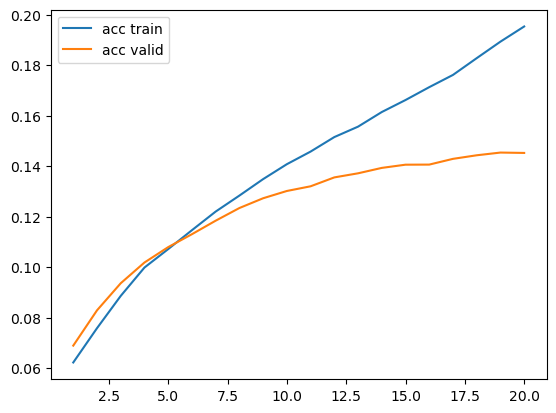

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='acc train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='acc valid')
plt.show()

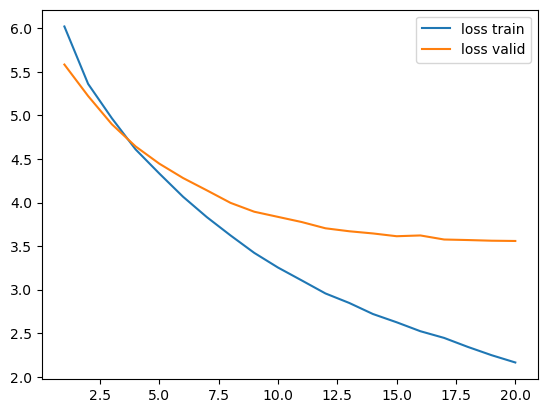

In [40]:
epoch_count = range(1, len(history1['loss']) + 1)
sns.lineplot(x=epoch_count,  y=history1['loss'], label='loss train')
sns.lineplot(x=epoch_count,  y=history1['val_loss'], label='loss valid')
plt.show()

### 5 - Inferencia

Step 1:
A deal is a deal -> Encoder -> enc(h1,c1)

enc(h1,c1) + \<sos> -> Decoder -> Un + dec(h1,c1)

step 2:
dec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)

step 3:
dec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)

step 4:
dec(h3,c3) + es -> Decoder -> un + dec(h4,c4)

step 5:
dec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)

step 6:
dec(h5,c5) + trato. -> Decoder -> \<eos> + dec(h6,c6)

In [41]:
# Cargo el mejor modelo guardado
model.load_state_dict(torch.load(model_filename))

<All keys matched successfully>

In [42]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [43]:
def prepare_input(input: str):
    print('Input:', input)
    integer_seq = input_tokenizer.texts_to_sequences([input])[0]
    print("Representacion en vector de tokens de ids", integer_seq)
    encoder_sequence = pad_sequences([integer_seq], maxlen=max_input_len)
    print("Padding del vector:", encoder_sequence)
    encoder_sequence_tensor = torch.from_numpy(encoder_sequence.astype(np.int32))
    return encoder_sequence_tensor


In [44]:
input_test = "My mother say hi."
encoder_sequence_test_tensor = prepare_input(input_test)

# Se obtiene la salida del encoder (el estado oculto para el decoder)
prev_state = model.encoder(encoder_sequence_test_tensor.to(device))

# Se inicializa la secuencia de entrada al decoder como "<sos>"
target_seq = np.zeros((1, 1))
target_seq[0, 0] = word2idx_outputs['<sos>']
target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

# Se obtiene la primera palabra de la secuencia de salida del decoder
output, prev_state = model.decoder(target_seq_tensor.to(device), prev_state)

top1 = output.argmax(1)
idx = top1.item()
print("Index/token de salida:", idx)

word = idx2word_target[idx]
print("Palabra de salida:", word)

Input: My mother say hi.
Representacion en vector de tokens de ids [18, 203, 122, 2355]
Padding del vector: [[   0    0    0    0    0    0    0    0    0    0    0    0    0   18
   203  122 2355]]
Index/token de salida: 22
Palabra de salida: mi


In [45]:
def translate_sentence(input_seq):
    encoder_sequence_tensor = prepare_input(input_seq)

    # Se transforma la sequencia de entrada a los stados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder"
    prev_state = model.encoder(encoder_sequence_tensor.to(device))

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

    # Se obtiene el indice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output, new_prev_state = model.decoder(target_seq_tensor.to(device), prev_state)
        top1 = output.argmax(1).view(-1, 1)
        idx = int(top1.cpu())

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar ídx a palabra
        word = ''        
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dado la ultimo prediccion
        prev_state = new_prev_state

        # Actualizar secuencia de entrada con la salida (re-alimentacion)
        target_seq_tensor = top1

    return ' '.join(output_sentence)

In [46]:
input = input_sentences[0]
translation = translate_sentence(input)
print('-')
print('Input:', input)
print('Response:', translation)

Input: There is no doubt about his ability.
Representacion en vector de tokens de ids [43, 7, 65, 915, 55, 24, 1835]
Padding del vector: [[   0    0    0    0    0    0    0    0    0    0   43    7   65  915
    55   24 1835]]
-
Input: There is no doubt about his ability.
Response: no hay nada que él no tiene su


In [47]:
input_test = "My mother say hi."
translation = translate_sentence(input_test)
print('Response:', translation)

Input: My mother say hi.
Representacion en vector de tokens de ids [18, 203, 122, 2355]
Padding del vector: [[   0    0    0    0    0    0    0    0    0    0    0    0    0   18
   203  122 2355]]
Response: mi madre no a tom


In [48]:
i = np.random.choice(len(input_sentences))
input = input_sentences[i]
translation = translate_sentence(input)
print('-')
print('Input:', input)
print('Response:', translation)

Input: This is the house where Tom was brought up.
Representacion en vector de tokens de ids [16, 7, 1, 111, 83, 5, 13, 737, 56]
Padding del vector: [[  0   0   0   0   0   0   0   0  16   7   1 111  83   5  13 737  56]]
-
Input: This is the house where Tom was brought up.
Response: este es la casa donde tom se a tom


In [49]:
inputs = ["how you feel", "i'm feeling good", "my friend", "you are crazy", "are you crazy", "that is insane", "let's go home", 
          "A deal is a deal", "rest in peace", "a goal without a plan is just a wish", "never stop learning because life never stops teaching"]
for input in inputs:
    translation = translate_sentence(input)
    print('Response:', translation)
    print('----------')


Input: how you feel
Representacion en vector de tokens de ids [47, 4, 211]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0  47   4 211]]
Response: cómo te sientes
----------
Input: i'm feeling good
Representacion en vector de tokens de ids [32, 613, 71]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0  32 613  71]]
Response: estoy bien
----------
Input: my friend
Representacion en vector de tokens de ids [18, 250]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  18 250]]
Response: es mi amigo
----------
Input: you are crazy
Representacion en vector de tokens de ids [4, 22, 689]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   4  22 689]]
Response: eres demasiado
----------
Input: are you crazy
Representacion en vector de tokens de ids [22, 4, 689]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0  22   4 689]]
Response: eres realmente
-

Creamos la función de entrenamiento modificada para la búsqueda de hiperparámetros

In [50]:
def optimizer_fit(trial, model, train_loader, valid_loader, optimizer, criterion, device, epochs, clip, teacher_forcing_ratio):
    history = train(model, train_loader, valid_loader, optimizer, criterion, device, epochs, clip, teacher_forcing_ratio)
    best_train_loss = min(history["loss"])
    best_val_loss = min(history["val_loss"])
    best_train_acc = max(history["accuracy"])
    best_val_acc = max(history["val_accuracy"])
    print(f'trial {trial.number}. BEST: Train loss {best_train_loss:.3f} - Train accuracy {best_train_acc:.3f} '
          + f'- Valid Loss {best_val_loss:.3f} - Valid accuracy {best_val_acc:.3f}')
    return best_val_loss

Creamos el experimento de Optuna

In [51]:
def champion_callback(study, frozen_trial):
    """
    Mostramos menos información, sino es demasiado verboso
    """
    # Obtener el mejor valor previo registrado en user_attrs
    winner = study.user_attrs.get("winner", None)
    
    # Si el valor actual supera al ganador anterior
    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        
        if winner:
            # Calcular la mejora porcentual
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value:.5f} with "
                f"{improvement_percent:.2f}% improvement"
            )
        else:
            # Primer ganador registrado
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value:.5f}")
    elif frozen_trial.number % 10 == 0:
        # Mostrar progreso cada 10 trials
        print(f"Trial {frozen_trial.number} with no changes.")

def objective(trial):

    lstm_size = trial.suggest_categorical("lstm_size", [64, 128, 256])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout_enc = trial.suggest_float("dropout_enc", 0.0, 0.5)
    dropout_dec = trial.suggest_float("dropout_dec", 0.0, 0.5)
    embedding_enc = trial.suggest_categorical("embedding_enc", ["glove", "fasttext"])
    embedding_dec = trial.suggest_categorical("embedding_dec", ["empty", "fasttext"])
    embedding_model_enc = embedding_glove_eng if (embedding_enc == "glove") else embedding_fasttext_eng
    embedding_model_dec = Empty_Embeddings(50, word2idx_outputs) if (embedding_dec == "empty") else embedding_fasttext_esp
    encoder = Encoder(embedding_model_enc, dropout=dropout_enc, lstm_size=lstm_size, num_layers=num_layers)
    decoder = Decoder(embedding_model_dec, dropout=dropout_dec, lstm_size=lstm_size, num_layers=num_layers)
    model = Seq2Seq(encoder, decoder, device)
    teacher_forcing_ratio = trial.suggest_float("teacher_forcing_ratio", 0.5, 1.0)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=0)  # Para clasificación multi categórica
    
    print(f"Trial {trial.number}. lstm_size {lstm_size} - num_layers {num_layers} - dropout_enc {dropout_enc:.2f} - dropout_dec {dropout_dec:.2f} " +
            f"- embedding_enc {embedding_enc} - embedding_dec {embedding_dec} - teacher_forcing_ratio {teacher_forcing_ratio:.2f}")
    score = optimizer_fit(trial, model, train_dataloader, val_dataloader, optimizer, criterion, device, epochs=20, 
                          clip=1.0, teacher_forcing_ratio=teacher_forcing_ratio)
    
    return score


In [52]:
import optuna 
# Creamos un estudio de Optuna
# Optuna es un poco verboso, dejamos que solo nos muestre logs de errores
optuna.logging.set_verbosity(optuna.logging.ERROR)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[champion_callback])

Trial 0. lstm_size 64 - num_layers 3 - dropout_enc 0.14 - dropout_dec 0.23 - embedding_enc fasttext - embedding_dec fasttext - teacher_forcing_ratio 0.96
Epoch: 1/20 - Train loss 6.227 - Train accuracy 0.058 - Valid Loss 5.839 - Valid accuracy 0.064 - Train PPX 506.140 - Valid PPX 343.567
Epoch: 2/20 - Train loss 5.728 - Train accuracy 0.066 - Valid Loss 5.624 - Valid accuracy 0.069 - Train PPX 307.345 - Valid PPX 277.028
Epoch: 3/20 - Train loss 5.481 - Train accuracy 0.073 - Valid Loss 5.420 - Valid accuracy 0.077 - Train PPX 239.968 - Valid PPX 225.783
Epoch: 4/20 - Train loss 5.267 - Train accuracy 0.080 - Valid Loss 5.221 - Valid accuracy 0.083 - Train PPX 193.864 - Valid PPX 185.062
Epoch: 5/20 - Train loss 5.068 - Train accuracy 0.085 - Valid Loss 5.047 - Valid accuracy 0.088 - Train PPX 158.805 - Valid PPX 155.554
Epoch: 6/20 - Train loss 4.898 - Train accuracy 0.089 - Valid Loss 4.889 - Valid accuracy 0.092 - Train PPX 133.963 - Valid PPX 132.842
Epoch: 7/20 - Train loss 4.745

In [53]:
import pandas as pd
# Visualizamos los mejores hiperparámetros encontrados
print("Best parameters:")
display(pd.DataFrame(study.best_params, index=['Value']))

Best parameters:


,lstm_size,num_layers,dropout_enc,dropout_dec,embedding_enc,embedding_dec,teacher_forcing_ratio
Value,256,1,0.265603,0.252338,glove,fasttext,0.976264


In [54]:
# Entrenamos el modelo y guardamos el mejor según validación
embedding_model_enc = embedding_glove_eng if (study.best_params["embedding_enc"] == "glove") else embedding_fasttext_eng
embedding_model_dec = Empty_Embeddings(50, word2idx_outputs) if (study.best_params["embedding_dec"] == "empty") else embedding_fasttext_esp
lstm_size = study.best_params["lstm_size"]
num_layers = study.best_params["num_layers"]
encoder = Encoder(embedding_model_enc, dropout=study.best_params["dropout_enc"], lstm_size=lstm_size, num_layers=num_layers)
decoder = Decoder(embedding_model_dec, dropout=study.best_params["dropout_dec"], lstm_size=lstm_size, num_layers=num_layers)
model = Seq2Seq(encoder, decoder, device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)  # Para clasificación multi categórica

model_filename_best = "best_translator.pt"
history1 = train(model, train_dataloader, val_dataloader, optimizer, criterion, device, epochs=20, 
                 teacher_forcing_ratio=study.best_params["teacher_forcing_ratio"], model_filename=model_filename_best)

# Al finalizar, cargo el mejor modelo
model.load_state_dict(torch.load(model_filename_best))

Epoch: 1/20 - Train loss 5.907 - Train accuracy 0.064 - Valid Loss 5.467 - Valid accuracy 0.073 - Train PPX 367.692 - Valid PPX 236.668
Epoch: 2/20 - Train loss 5.124 - Train accuracy 0.083 - Valid Loss 4.897 - Valid accuracy 0.091 - Train PPX 167.927 - Valid PPX 133.821
Epoch: 3/20 - Train loss 4.616 - Train accuracy 0.096 - Valid Loss 4.495 - Valid accuracy 0.104 - Train PPX 101.086 - Valid PPX  89.601
Epoch: 4/20 - Train loss 4.217 - Train accuracy 0.106 - Valid Loss 4.228 - Valid accuracy 0.112 - Train PPX  67.854 - Valid PPX  68.566
Epoch: 5/20 - Train loss 3.894 - Train accuracy 0.115 - Valid Loss 3.999 - Valid accuracy 0.120 - Train PPX  49.124 - Valid PPX  54.537
Epoch: 6/20 - Train loss 3.609 - Train accuracy 0.123 - Valid Loss 3.821 - Valid accuracy 0.128 - Train PPX  36.934 - Valid PPX  45.634
Epoch: 7/20 - Train loss 3.358 - Train accuracy 0.130 - Valid Loss 3.669 - Valid accuracy 0.134 - Train PPX  28.721 - Valid PPX  39.200
Epoch: 8/20 - Train loss 3.142 - Train accuracy 

<All keys matched successfully>

### 6 - Conclusión
A primera vista parece que el modelo tendría que funcionar muy bien por el accuracy alcanzado. La realidad es que las respuestas no tienen que ver demasiado con la pregunta/traducción pero la respuesta en si tiene bastante coherencia.\
Para poder mejorar el modelo haría falta poder consumir todo el dataset y todo el vocabulario, pero la cantidad de RAM no es suficiente.\
Este problema se resuelve con:
- Utilizando un DataGenerator para no levantar todo el dataset junto en el entrenamiento.
- Transfer learning evitando tener que entrenar todo el modelo  